<a href="https://colab.research.google.com/github/mohamedyosef101/101_learning_area/blob/area/PyTorch/vanilla_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vanilla** Neural Network
The original notebook created by [Andrada](https://www.kaggle.com/code/andradaolteanu/how-i-taught-myself-deep-learning-vanilla-nns#1.-Introduction)

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader as dl

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

sns.set()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Available device:", device)

Available device: cpu


# 1. **Load** the data

In [34]:
# hide the output
%%capture

train = datasets.MNIST('data',
                       train=True,
                       download=True,
                       transform=ToTensor())

test = datasets.MNIST('data',
                      train=False,
                      download=True,
                      transform=ToTensor())

# 2. Data **Exploration**

In [35]:
image, label = train[0]
image.shape

torch.Size([1, 28, 28])

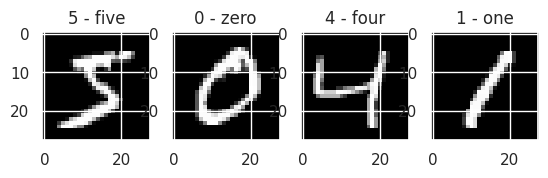

In [36]:
# get a sample
for i in range(4):
  image, label = train[i]
  plt.subplot(1, 4, i+1)
  plt.imshow(image.squeeze(), cmap='gray')
  plt.title(train.classes[label])

# 3. **Initial** Model

In [88]:
class MNISTClassifier(nn.Module):
  def __init__(self):
    super(MNISTClassifier, self).__init__()
    self.layers = nn.Sequential(nn.Linear(28*28, 50),
                                nn.ReLU(),
                                nn.Linear(50, 20),
                                nn.ReLU(),
                                nn.Linear(20, 10))

  def forward(self, image, prints=True):
    if prints: print(f'Image shape: {image.detach().numpy().shape}')

    # flatten image from [1, 28, 28] to [784]
    image = image.view(-1, 28*28)
    if prints: print(f"Image reshaped: {image.detach().numpy().shape}")

    out = self.layers(image)
    if prints: print('Out shape:', out.detach().numpy().shape)

    return out

`detach().numpy()` is just a way to make the output look nicer.

### Check the model

In [89]:
image_example, label_example = train[5]
print('The true label is:', label_example, '\n')

model_example = MNISTClassifier()

out = model_example(image_example)
print('out:', out.detach().numpy(), '\n')

# Choose max prob.
pred = out.max(dim=1)[1]
pred = pred.item()

print('prediction:', pred, '\n')

print('Model get it -> ', pred == label_example)

The true label is: 2 

Image shape: (1, 28, 28)
Image reshaped: (1, 784)
Out shape: (1, 10)
out: [[-0.07011589  0.07127549  0.03738871  0.05102511  0.12294894  0.00151575
  -0.14964236  0.2695161   0.08558195 -0.22980976]] 

prediction: 7 

Model get it ->  False


### Loss and Optimizer

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_example.parameters(), lr=0.005, momentum=0.9)

print('Loss:', criterion, '\n', '\n' +
      'Optimizer:', optimizer)

Loss: CrossEntropyLoss() 
 
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.005
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### Model Parameters & Backpropagation
How many parameters (weights and biases) are updating during 1 single backpropagation.

In [73]:
params = list(model_example.parameters())

for i in range(len(params)):
  print('Parameter', i+1, ':', params[i].detach().numpy().shape)

Parameter 1 : (50, 784)
Parameter 2 : (50,)
Parameter 3 : (20, 50)
Parameter 4 : (20,)
Parameter 5 : (10, 20)
Parameter 6 : (10,)


In [91]:
# clear gradients
optimizer.zero_grad()

# compute loss
loss = criterion(out, torch.tensor(label_example).reshape(-1))
print('Loss:', loss.detach().numpy())

# compute gradients
loss.backward()

# update weights
optimizer.step()

Loss: 2.293136


# 4. **Training** Neural Network

Create a `DataLoader` and  split the data into 1000 batch each one with size of 60 data point.

> `shuffle=True` to shuffle the images after every epoch.

In [96]:
# Data Loader -> dl
train_loader = dl(train, batch_size=60, shuffle=True)
test_loader = dl(test, batch_size=10, shuffle=True)

# select first batch
images, labels = next(iter(train_loader))
print('Object shape:', images.detach().numpy().shape, '\n\n' +
      'Total Inages:', labels.detach().numpy().shape)

Object shape: (60, 1, 28, 28) 

Total Inages: (60,)


### Train a batch

In [98]:
n = 0
for i, (images, labels) in enumerate(train_loader):
  if i >= 3:
    break

  print('====== Batch', i, ':')
  out = model_example(images)

  loss = criterion(out, labels)
  print('loss', loss)

  print('Optimizing...')
  loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  print('Done.')

  if i < 2: print('\n')

====== Batch 0 :
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss tensor(2.3267, grad_fn=<NllLossBackward0>)
Optimizing...
Done.


====== Batch 1 :
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss tensor(2.3191, grad_fn=<NllLossBackward0>)
Optimizing...
Done.


====== Batch 2 :
Image shape: (60, 1, 28, 28)
Image reshaped: (60, 784)
Out shape: (60, 10)
loss tensor(2.2765, grad_fn=<NllLossBackward0>)
Optimizing...
Done.
